In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/jhernandez/Work//python_tools')
import tools
import os
from glob import glob

In [2]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle,ScipyParticle,Field, AdvectionRK4_3D, AdvectionRK4,BrownianMotion2D, OutOfBoundsError,  KernelError,plotTrajectoriesFile,random

In [5]:

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta, datetime
from operator import attrgetter

### Launch Parcels particles for HFR DIVAnd reconstructed field

    - For Oct 2014, in coincidence with DA experiments, use HFR DIVAnd fields
    - Launch particles and evaluate in comparison to WMOP DA 
    - Use drifters as well for validation

In [6]:
from advection_diffusion import *

#### Drifters files

In [7]:
files_drifters = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*')
files_drifters.sort()

##### Some particle parameters

In [8]:
particles_n = 50
dt = timedelta(minutes=30)
integration_time = timedelta(hours=24*3)
output_dt = timedelta(minutes=60)
ND = 1000


#### Function: generate_initial_position_particles

In [9]:
def generate_initial_position_particles(lons, lats, ND, diffussion=True):
    
    if diffussion == True:
        # Create arrays for initial position particles
        lon0 = np.repeat(lons,ND)
        lat0 = np.repeat(lats,ND)
        
    else:
        inc_mag=0.01
        lat0 = []
        lon0 = []
        for i in range(len(lats)):
            lat = [lats[i]-(np.random.rand()*inc_mag) for n in range(ND)]
            lon = [lons[i]+(np.random.rand()*inc_mag) for n in range(ND)]
            lat0 = lat0 + lat
            lon0 = lon0 + lon
        lat0 = np.array(lat0)
        lon0 = np.array(lon0)
            
    depths = lat0*0
    
    return lon0, lat0, depths

##### Create new particle class

In [10]:
class PlasticParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    # beached : 0 sea, 1 beached, 2 after non-beach dyn, 3 after beach dyn, 4 please unbeach
    beached = Variable('beached', dtype=np.int32, initial=0.)
    unbeachCount = Variable('unbeachCount', dtype=np.int32, initial=0.)
    
def DeleteParticle(particle, fieldset, time):
    particle.delete()

#### Example (by Laura Navarro)
    Execute particle Set and eliminate any particle OutofBounds

In [12]:
#pset_AZO_grid_v2.execute(AdvectionRK4, runtime=timedelta(days=7.), dt=timedelta(minutes=5),
 #            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

### Get HFR DIVAnd fields

In [11]:
file_diva = '/home/jhernandez/Work/data/SDC_IBIZACHANNEL_HFRadar_DP1.nc'
ds_hfr = xr.open_dataset(file_diva)

In [12]:
def prepare_diva_field(ds):
    """ Extend lon, lat in order to put a frame of NaN values,
    so particles beach when get out of the domain """
    
    lon = ds.lon.values
    lat = ds.lat.values

    lon_diff = np.diff(lon)[0]
    lat_diff = np.diff(lat)[0]

    lon = np.append(lon, [lon[-1] + lon_diff, lon[-1] + 2*lon_diff])
    lon = np.append([lon[0] - 2*lon_diff, lon[0] - lon_diff], lon)

    lat = np.append(lat, [lat[-1] + lat_diff, lat[-1] + 2*lat_diff])
    lat = np.append([lat[0] - 2*lat_diff, lat[0] - lat_diff], lat)

    nz, ny, nx = ds.u.shape
    u = np.empty((nz, ny+4, nx+4))
    u[:] = np.nan
    v = np.empty((nz, ny+4, nx+4))
    v[:]= np.nan

    u[:,2:-2,2:-2] = ds.u.values
    v[:,2:-2,2:-2] = ds.v.values
    
    return lon, lat, u, v
    

In [14]:


def prepare_diva_field(ds, persistency=False, mean_flag=0):
    """ Extend lon, lat in order to put a frame of NaN values,
    so particles beach when get out of the domain """
    
    lon = ds.lon.values
    lat = ds.lat.values

    lon_diff = np.diff(lon)[0]
    lat_diff = np.diff(lat)[0]

    lon = np.append(lon, [lon[-1] + lon_diff, lon[-1] + 2*lon_diff])
    lon = np.append([lon[0] - 2*lon_diff, lon[0] - lon_diff], lon)

    lat = np.append(lat, [lat[-1] + lat_diff, lat[-1] + 2*lat_diff])
    lat = np.append([lat[0] - 2*lat_diff, lat[0] - lat_diff], lat)

    nz, ny, nx = ds.u.shape

    
    if mean_flag == 0:

        u = np.empty((nz, ny+4, nx+4))
        v = np.empty((nz, ny+4, nx+4))
        u[:] = np.nan
        v[:] = np.nan

        if persistency == True:

            for i in range(ds.time.shape[0]):
                u[i,2:-2,2:-2] = ds.u[0,:,:]
                v[i,2:-2,2:-2] = ds.v[0,:,:]
        else:
            u[:,2:-2,2:-2] = ds.u.values
            v[:,2:-2,2:-2] = ds.v.values

    elif mean_flag == 1:

        u = np.empty((nz//24, ny+4, nx+4))
        v = np.empty((nz//24, ny+4, nx+4))
        u[:] = np.nan
        v[:] = np.nan

        for i in range(nz//24):
            u[i,2:-2,2:-2] = ds.u[24*i:24*(i+1),:,:].mean(axis=0)
            v[i,2:-2,2:-2] = ds.v[24*i:24*(i+1),:,:].mean(axis=0)
        
    
    return lon, lat, u, v

## Launch Simulation

- 3 days lagrangian simulation
- WMOP ASSIM his fields are used from waverider
- Each day 2000 particles launched. 1000 at the position of the drifter at 00:00 the initial date
- kernels for AdvectionRK4, Brownian 2D and Beaching included

In [15]:
import time

In [22]:
date = datetime(2014,10,1)
ndays=5
mean_flag=0

for i in range(8):

    print(date)
    t0_field = time.time()

    strdate_ini = date.strftime('%Y%m%d')
    strdate_end = (date + timedelta(days=ndays) ).strftime('%Y%m%d')

    ds_sel = ds_hfr.sel(time=slice(strdate_ini, strdate_end))
    times = ds_sel.time.values.astype(datetime)/10**9
    
    if mean_flag==1:
        times = times[::24]

    lon, lat, u, v = prepare_diva_field(ds_sel, mean_flag=0, persistency=True)

    fieldset = FieldSet.from_data(
        {'U':u,'V':v},
        {'U':{'lon':lon,'lat':lat,'time': times},
         'V':{'lon':lon,'lat':lat,'time': times}} )

    # diffussion parameters
    kh_zonal = 20 # in m^2/s
    kh_meridional = 20  # in m^2/s

    # Create field of Kh_zonal and Kh_meridional, using same grid as U
    grid = fieldset.U.grid
    fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones(u.shape), grid=grid))
    fieldset.add_field(Field('Kh_meridional', kh_zonal*np.ones(u.shape), grid=grid))

    # Get Initial position of particles
    lons = []
    lats = []

    for file in files_drifters:
        ds_drif = xr.open_dataset(file)
        ds_drif = ds_drif.sel(time=date.strftime('%Y-%m-%d'))

        if ds_drif.time.shape[0] == 0:
            print(F"No time close to target for Drifer:  {file.split('/')[-1]}")
        else:
            lons.append( ds_drif.LON.values[0])
            lats.append( ds_drif.LAT.values[0])

    # Create arrays for initial position particles
    lon0, lat0, depths = generate_initial_position_particles(lons, lats, ND, diffussion=True)
                  
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=PlasticParticle,  # the type of particles (JITParticle or ScipyParticle)
                             #time=release_time,
                             lon=lon0, # a vector of release longitudes 
                             lat=lat0,
                             depth=depths)

    #runtime = (end_date - start_date).as_timedelta()
    runtime = timedelta(days=5)

    kernel =  pset.Kernel(AdvectionRK42) + pset.Kernel(BeachTesting_2D) + pset.Kernel(BrownianMotion2D2) + pset.Kernel(BeachTesting_2D)

    output_path = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/"

    if os.path.isdir(output_path)==False:
        os.system(F"mkdir {output_path}")

    output_name = F"{output_path}/wmop_advection_{strdate_ini}_{strdate_end}.nc"

    # Execute lagrangian particle simulation  

    pset.execute( kernel,runtime=runtime, dt=dt,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
                 output_file=pset.ParticleFile(name=output_name, outputdt=output_dt))


    tf_field = time.time()

    print(F"Time spent to load Fieldset for {ndays} days = {tf_field-t0_field} seconds")

    date = date + timedelta(days=1)


2014-10-01 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/bfa123eed23d858f760510ea8f69ac8c_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-LFXIPTKS.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-LFXIPTKS" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:34 Time:  0:01:34


Time spent to load Fieldset for 5 days = 116.80587434768677 seconds
2014-10-02 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/ca819d2267519a7448138a70f88781fe_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-NZKHVBDU.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-NZKHVBDU" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:33 Time:  0:01:33


Time spent to load Fieldset for 5 days = 121.24473714828491 seconds
2014-10-03 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/935fa2dd75ee5274365ad147ce81f4c8_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-DUNOVVJL.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-DUNOVVJL" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:31 Time:  0:01:31


Time spent to load Fieldset for 5 days = 119.357097864151 seconds
2014-10-04 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/2b7c834eef71574cc9bec3bffd5c5e99_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-VYSKVHQU.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-VYSKVHQU" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:32 Time:  0:01:32


Time spent to load Fieldset for 5 days = 120.61684703826904 seconds
2014-10-05 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/8b0e98b549b03bf28af72fb2f469bddc_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-PBSQIRBV.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-PBSQIRBV" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:32 Time:  0:01:32


Time spent to load Fieldset for 5 days = 121.16438746452332 seconds
2014-10-06 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/ef2cf98230510bdb9aa0b735a311314c_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-XJYYNRFP.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-XJYYNRFP" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:32 Time:  0:01:32


Time spent to load Fieldset for 5 days = 120.99695086479187 seconds
2014-10-07 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/e47758f891b820da147b33f92144ef51_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-DUOGHZFR.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-DUOGHZFR" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:23 Time:  0:01:23


Time spent to load Fieldset for 5 days = 112.40062427520752 seconds
2014-10-08 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/8ca482545bde960b9f111ea5a1b3af6d_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-HWQNHBXR.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_persistency/out-HWQNHBXR" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:09 Time:  0:01:09


Time spent to load Fieldset for 5 days = 98.01953387260437 seconds


In [20]:
files = glob('/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_v2/*nc')
files.sort()
for f in files:
    ds = xr.open_dataset(f)
    print(ds.lon.shape)

(14000, 121)


In [25]:
date = datetime(2014,10,1)
ndays=5

for i in range(8):

    print(date)
    t0_field = time.time()

    strdate_ini = date.strftime('%Y%m%d')
    strdate_end = (date + timedelta(days=ndays) ).strftime('%Y%m%d')

    ds_sel = ds_hfr.sel(time=slice(strdate_ini, strdate_end))
    times = ds_sel.time.values.astype(datetime)/10**9

    lon, lat, u, v = prepare_diva_field(ds_sel)

    fieldset = FieldSet.from_data(
        {'U':u,'V':v},
        {'U':{'lon':lon,'lat':lat,'time': times},
         'V':{'lon':lon,'lat':lat,'time': times}} )

    # diffussion parameters
    kh_zonal = 20 # in m^2/s
    kh_meridional = 20  # in m^2/s

    # Create field of Kh_zonal and Kh_meridional, using same grid as U
    grid = fieldset.U.grid
    fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones(u.shape), grid=grid))
    fieldset.add_field(Field('Kh_meridional', kh_zonal*np.ones(u.shape), grid=grid))

    # Get Initial position of particles
    lons = []
    lats = []

    for file in files_drifters:
        ds_drif = xr.open_dataset(file)
        ds_drif = ds_drif.sel(time=date.strftime('%Y-%m-%d'))

        if ds_drif.time.shape[0] == 0:
            print(F"No time close to target for Drifer:  {file.split('/')[-1]}")
        else:
            lons.append( ds_drif.LON.values[0])
            lats.append( ds_drif.LAT.values[0])

    # Create arrays for initial position particles
    lon0, lat0, depths = generate_initial_position_particles(lons, lats, 1, diffussion=True)
                  
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=PlasticParticle,  # the type of particles (JITParticle or ScipyParticle)
                             #time=release_time,
                             lon=lon0, # a vector of release longitudes 
                             lat=lat0,
                             depth=depths)

    #runtime = (end_date - start_date).as_timedelta()
    runtime = timedelta(days=5)

    kernel =  pset.Kernel(AdvectionRK42) + pset.Kernel(BeachTesting_2D)

    output_path = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_single/"

    if os.path.isdir(output_path)==False:
        os.system(F"mkdir {output_path}")

    output_name = F"{output_path}/wmop_advection_{strdate_ini}_{strdate_end}.nc"

    # Execute lagrangian particle simulation  

    pset.execute( kernel,runtime=runtime, dt=dt,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
                 output_file=pset.ParticleFile(name=output_name, outputdt=output_dt))


    tf_field = time.time()

    print(F"Time spent to load Fieldset for {ndays} days = {tf_field-t0_field} seconds")

    date = date + timedelta(days=1)


2014-10-01 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/54b96e517a49096a41af6a40c161cce5_0.so


Time spent to load Fieldset for 5 days = 6.150906801223755 seconds
2014-10-02 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/f5e7cb8953ec51a0b0b95ef4aa9932cd_0.so


Time spent to load Fieldset for 5 days = 5.8923094272613525 seconds
2014-10-03 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/30a75abe410cd8186b0524d7cc98e9c2_0.so


Time spent to load Fieldset for 5 days = 5.958813428878784 seconds
2014-10-04 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/59f9260fd06f07052169a28384560a4a_0.so


Time spent to load Fieldset for 5 days = 5.923049449920654 seconds
2014-10-05 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/ac5740facd618ae17fda770639c99870_0.so


Time spent to load Fieldset for 5 days = 5.870029926300049 seconds
2014-10-06 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/2bdccb3322b47cbfe4eb827654815c62_0.so


Time spent to load Fieldset for 5 days = 6.014769077301025 seconds
2014-10-07 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/1cb446f7df2c4ee0c1d85bf0fb4d3ccb_0.so


Time spent to load Fieldset for 5 days = 5.92447304725647 seconds
2014-10-08 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/a48415ef38ef796643a3ab8b16c5f711_0.so


Time spent to load Fieldset for 5 days = 5.961092472076416 seconds


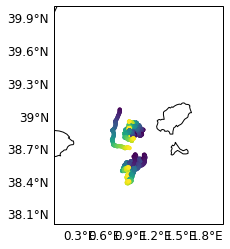

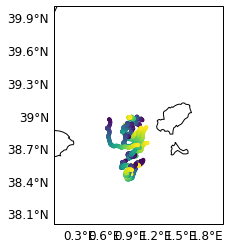

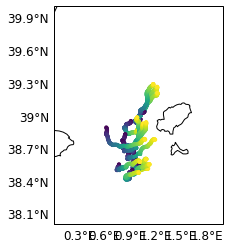

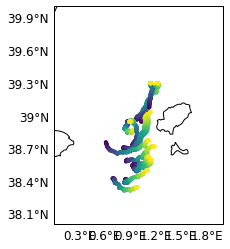

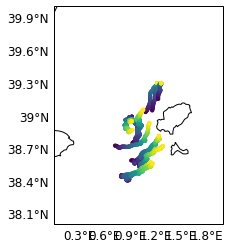

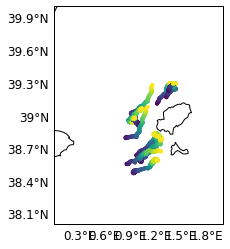

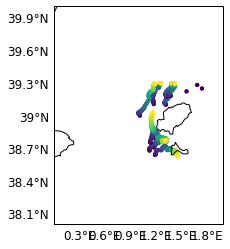

In [29]:
files = glob('/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields_single/*nc')
files.sort()
for f in files:
    ds = xr.open_dataset(f)
    #print(ds.lon.shape)
    plt.figure()
    
    ax, gl = tools.make_map(continents=False, limits=[0,2,38,40])
    for i in range(14):
        plt.scatter(ds.lon[i,:], ds.lat[i,:], 10, ds.time[i,:], transform=gl.crs)

In [39]:
import seawater as sw

# Drifter files
drifter_files = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*nc')
drifter_files.sort()

#experiment_list = ['DIVAnd-fields', 'HFR_radials_raw_Oct2014']#, 'HFR_radial_nonudging_Oct2014_v15', 'HFR_radial_nonudging_Oct2014_v16', 'HFR_radial_nonudging_Oct2014_v17']

dist_mean = {}
dl_cm = {}
dist_all = {}

ndays = 8
ndrif = 13
nt = 121  #ds0.time.shape[1]

# Initialize for inicial position of drifter
lon0 = np.empty((ndrif, ndays)) #* np.nan
lat0 = np.empty((ndrif, ndays)) #* np.nan


## Set limits of DIVA field  --- DISTANCE will only be calculated whithin this area
lonmax_hfr = ds_hfr.lon.max().values
lonmin_hfr = ds_hfr.lon.min().values
latmax_hfr = ds_hfr.lat.max().values
latmin_hfr = ds_hfr.lat.min().values


experiment_list = {'DIVA': ['DIVAnd-fields_single', 'fuchsia', 'DIVA']}

for exp in experiment_list:

    # Distance travelled by dritfer every hour
    dl_drif = np.empty((ndays, nt-1, ndrif))

    print(exp)

    # Dates
    date_ini = datetime(2014,10,1)

    # Initialize distance matrix
    dist_mean[exp] = np.empty((nt, ndays))
    dl_cm[exp] = np.empty((ndays, nt-1, ndrif))
    dist_all[exp] = np.empty((ndays, nt, ndrif))

    for nday in range(ndays):

        date_end = date_ini + timedelta(days=5)

        strdate = date_ini.strftime('%Y%m%d')
        strdate_end = date_end.strftime('%Y%m%d')
        #print(strdate)

        # Path to virtual particle file
        folder = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/{experiment_list[exp][0]}/"
        file_virtual = F"{folder}/wmop_advection_{strdate}_{strdate_end}.nc"

        # Load Virtual particles for selected date
        ds = xr.open_dataset(file_virtual)

        dist_cm = np.empty((nt, ndrif))

        # Time of virtual particle simulations
        tp = ds.time.values
        tp = pd.to_datetime( np.unique(tp) )
        tp = tp[tp.notnull()]  # extract NaT values - (when ErrorBound)

        #ndrif0 = min(ds.lon[0::1000,0].shape[0], ndrif)
        lon0[:,nday] = ds.lon[:,0][0:ndrif]
        lat0[:,nday] = ds.lat[:,0][0:ndrif]
        
        # Loop in drifters
        for ii in range(ndrif):

            # Extract lon, lat and time for corresponding drifter
            lonp = ds.lon[ii:(ii+1),:].values
            latp = ds.lat[ii:(ii+1),:].values

            i_out = (lonp > lonmin_hfr) & (lonp < lonmax_hfr) & (latp > latmin_hfr) & (latp > latmax_hfr)
            lonp[i_out] = np.nan
            latp[i_out] = np.nan

            # Load drifter data
            ds_drif = xr.open_dataset( drifter_files[ii] )

            # Subset to virtual particles period
            ds_drif2 = ds_drif.sel(time=slice(tp[0],tp[-1] ))

            ds_drif2.LON[ds_drif2.QC_LON!=1] = np.nan
            ds_drif2.LAT[ds_drif2.QC_LAT!=1] = np.nan

            # Interpolate LON Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LON, index=ds_drif2.time.values)    
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            lond = df.values

            # Interpolate LAT Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LAT, index=ds_drif2.time.values)
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            latd = df.values

            # Calculate CM for virtual particles corresponding to drifter
            lonp_mean = np.nanmean(lonp, axis=0)
            latp_mean = np.nanmean(latp, axis=0)


            for i in range(nt):
                # Distance between virtual particles and drifter
                x = [lond[i], lonp_mean[i]]
                y = [latd[i], latp_mean[i]]

                dist_cm[i,ii] = sw.dist(x, y, units='km')[0]

            for i in range(nt-1):
                # Distance travelled by Virtual Particles between two time steps
                xd = [lonp_mean[i], lonp_mean[i+1]]
                yd = [latp_mean[i], latp_mean[i+1]]

                dl_cm[exp][nday,i,ii] = sw.dist(xd, yd, units='km')[0]

                # Distance travelled by Drifter between two time steps
                xd = [lond[i], lond[i+1]]
                yd = [latd[i], latd[i+1]]

                dl_drif[nday,i,ii] = sw.dist(xd, yd, units='km')[0]

        dist_all[exp][nday,:,:] = dist_cm

        # Mean distance for each day, over the number of drifters
        dist_mean[exp][:,nday] = np.nanmean(dist_cm, axis=1)
        date_ini = date_ini + timedelta(days=1)

print('DONE!')

DIVA
DONE!


###   Compare Velocites for DIVA: raw, persistency, Mean

In [48]:
lon, lat, u_mean, v_mean = prepare_diva_field(ds_hfr, mean_flag=1)
lon, lat, u_raw, v_raw = prepare_diva_field(ds_hfr, mean_flag=0, persistency=False)
lon, lat, u_per, v_per = prepare_diva_field(ds_hfr, mean_flag=0, persistency=True)

t = ds_hfr.time.values


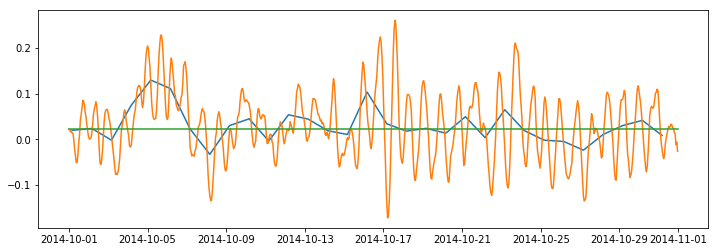

In [49]:
plt.figure(figsize=(12,4))
plt.plot(t[4::24], u_mean[:,15,15])
plt.plot(t, u_raw[:,15,15])
plt.plot(t, u_per[:,15,15])

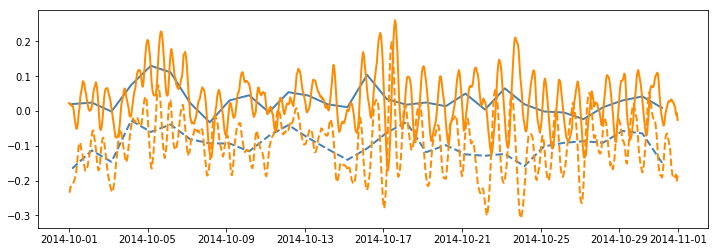

In [53]:
plt.figure(figsize=(12,4))
plt.plot(t[4::24], u_mean[:,15,15], color='steelblue', linewidth=2)
plt.plot(t[4::24], v_mean[:,15,15], '--', color='steelblue', linewidth=2)

plt.plot(t, u_raw[:,15,15], color='darkorange', linewidth=2)
plt.plot(t, v_raw[:,15,15],'--', color='darkorange', linewidth=2)

plt.show()

In [ ]:


def prepare_diva_field(ds, persistency=False, mean_flag=0):
    """ Extend lon, lat in order to put a frame of NaN values,
    so particles beach when get out of the domain """
    
    lon = ds.lon.values
    lat = ds.lat.values

    lon_diff = np.diff(lon)[0]
    lat_diff = np.diff(lat)[0]

    lon = np.append(lon, [lon[-1] + lon_diff, lon[-1] + 2*lon_diff])
    lon = np.append([lon[0] - 2*lon_diff, lon[0] - lon_diff], lon)

    lat = np.append(lat, [lat[-1] + lat_diff, lat[-1] + 2*lat_diff])
    lat = np.append([lat[0] - 2*lat_diff, lat[0] - lat_diff], lat)

    nz, ny, nx = ds.u.shape

    
    if mean_flag == 0:

        u = np.empty((nz, ny+4, nx+4))
        v = np.empty((nz, ny+4, nx+4))
        u[:] = np.nan
        v[:] = np.nan

        if persistency == True:

            for i in range(ds_sel.time.shape[0]):
                u[i,2:-2,2:-2] = ds.u[0,:,:]
                v[i,2:-2,2:-2] = ds.v[0,:,:]
        else:
            u[:,2:-2,2:-2] = ds.u.values
            v[:,2:-2,2:-2] = ds.v.values

    elif mean_flag == 1:

        u = np.empty((nz//24, ny+4, nx+4))
        v = np.empty((nz//24, ny+4, nx+4))
        u[:] = np.nan
        v[:] = np.nan

        for i in range(nz//24):
            u[i,2:-2,2:-2] = ds.u[24*i:24*(i+1),:,:].mean(axis=0)
            v[i,2:-2,2:-2] = ds.v[24*i:24*(i+1),:,:].mean(axis=0)
        
    
    return lon, lat, u, v

In [44]:
nz, ny, nx = ds_sel.u.shape

u = np.empty((nz, ny+4, nx+4))
v = np.empty((nz, ny+4, nx+4))
u[:] = np.nan
v[:] = np.nan


for i in range(ds_sel.time.shape[0]):
    u[i,2:-2,2:-2] = ds_sel.u[0,:,:]
    v[i,2:-2,2:-2] = ds_sel.v[0,:,:]

In [17]:
date = datetime(2014,10,1)
ndays=5
mean_flag=1

print(date)
t0_field = time.time()

strdate_ini = date.strftime('%Y%m%d')
strdate_end = (date + timedelta(days=ndays) ).strftime('%Y%m%d')

ds_sel = ds_hfr.sel(time=slice(strdate_ini, strdate_end))
times = ds_sel.time.values.astype(datetime)/10**9

if mean_flag==1:
    times = times[::24]

lon, lat, u, v = prepare_diva_field(ds_sel, mean_flag=0, persistency=True)

2014-10-01 00:00:00


In [19]:
u.shape

(144, 34, 39)

In [21]:
times.shape

(6,)